# DS SC22x
 
### 코비 브라이언트의 슛 성공 여부 예측해보기

이번 스프린트 챌린지에서는 故 코비 브라이언트 선수의 NBA 필드 골 시도들이 담긴 데이터셋을 다룹니다 (1996년 11월 3일부터 2016년 4월 13일까지의 정규 시즌과 플레이오프 시즌 기록).

여러분은 각 슛의 성공 여부를 슈팅의 대한 정보, 게임에 대한 정보를 통해서 예측해야 합니다. 이것은 상당히 어려운 예측입니다. 해당 데이터셋은 [NBA API]((https://github.com/swar/nba_api) 파이썬 라이브러리를 통해 수집 됐습니다. 

In [ ]:
# Google Colab으로 수행한다면 이 셀을 먼저 실행해주세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [57]:
# 데이터셋을 불러옵니다
import pandas as pd
url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/nba/nba_kobe_bryant.csv'
df = pd.read_csv(url)

# 데이터셋이 잘 불러졌는지 확인합니다
assert df.shape == (30697, 19)

# Part 1 - Data Preprocessing

## 1.1 분류를 위한 베이스라인 정확도를 계산하세요
>예측 해야하는 target은 `shot_made_flag` 입니다. 전체 데이터를 써서 baseline **accuracy score**를 계산하세요.

In [73]:
# 이 곳에 답안을 작성하십시오
import numpy as np
from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split, cross_val_score
from category_encoders import OneHotEncoder, TargetEncoder, OrdinalEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score


from category_encoders import TargetEncoder, HashingEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


import missingno as msno

In [13]:
?accuracy_score

In [15]:
# baseline accuracy score  - all fail assumption
df.shot_made_flag.value_counts().max()

base_pred = pd.Series(np.zeros(len(df)))  # all zero prediction

base_acc = accuracy_score(df['shot_made_flag'], base_pred)
print(f'baseline - all zero prediction accuracy : {base_acc}')

baseline - all zero prediction accuracy : 0.5526924455158485


In [21]:
# basic EDA
df.isnull().sum()  



game_id              0
game_event_id        0
player_name          0
period               0
minutes_remaining    0
seconds_remaining    0
action_type          0
shot_type            0
shot_zone_basic      0
shot_zone_area       0
shot_zone_range      0
shot_distance        0
loc_x                0
loc_y                0
shot_made_flag       0
game_date            0
htm                  0
vtm                  0
season_type          0
dtype: int64

결측치 없음 



In [24]:
df.describe()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag
count,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000
mean,2.476407e+07,249.190800,2.519432,4.885624,28.365085,13.437437,7.110499,91.107535,0.447308
std,7.755175e+06,150.003712,1.153665,3.449897,17.478949,9.374189,110.124578,87.791361,0.497224
min,2.000001e+07,2.000000,1.000000,0.000000,0.000000,0.000000,-250.000000,-44.000000,0.000000
25%,2.050008e+07,110.000000,1.000000,2.000000,13.000000,5.000000,-68.000000,4.000000,0.000000
50%,2.090035e+07,253.000000,3.000000,5.000000,28.000000,15.000000,0.000000,74.000000,0.000000
75%,2.960047e+07,368.000000,3.000000,8.000000,43.000000,21.000000,95.000000,160.000000,1.000000
max,4.990009e+07,659.000000,7.000000,11.000000,59.000000,79.000000,248.000000,791.000000,1.000000


In [25]:
df

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season
2,29600044,124,Kobe Bryant,2,8,37,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,1996-11-06,CHH,LAL,Regular Season
3,29600044,144,Kobe Bryant,2,6,34,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,1996-11-06,CHH,LAL,Regular Season
4,29600044,151,Kobe Bryant,2,5,27,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1,1996-11-06,CHH,LAL,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,21501228,272,Kobe Bryant,3,9,45,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-96,237,0,2016-04-13,LAL,UTA,Regular Season
30693,21501228,274,Kobe Bryant,3,9,40,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-4,0,1,2016-04-13,LAL,UTA,Regular Season
30694,21501228,281,Kobe Bryant,3,9,0,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,31,-32,313,0,2016-04-13,LAL,UTA,Regular Season
30695,21501228,200,Kobe Bryant,2,4,56,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,6,-5,1,2016-04-13,LAL,UTA,Regular Season


In [26]:
df.season_type.value_counts()

Regular Season    26198
Playoffs           4499
Name: season_type, dtype: int64

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,game_date,htm,vtm,season_type
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,1996-11-03,LAL,MIN,Regular Season
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,1996-11-05,NYK,LAL,Regular Season
2,29600044,124,Kobe Bryant,2,8,37,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1996-11-06,CHH,LAL,Regular Season
3,29600044,144,Kobe Bryant,2,6,34,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,1996-11-06,CHH,LAL,Regular Season
4,29600044,151,Kobe Bryant,2,5,27,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1996-11-06,CHH,LAL,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,21501228,272,Kobe Bryant,3,9,45,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-96,237,2016-04-13,LAL,UTA,Regular Season
30693,21501228,274,Kobe Bryant,3,9,40,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-4,0,2016-04-13,LAL,UTA,Regular Season
30694,21501228,281,Kobe Bryant,3,9,0,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,31,-32,313,2016-04-13,LAL,UTA,Regular Season
30695,21501228,200,Kobe Bryant,2,4,56,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,6,-5,2016-04-13,LAL,UTA,Regular Season


In [33]:
# ordinal encoding
X_df = df[df.columns.drop('shot_made_flag')]
y_df = df['shot_made_flag']

ordinal = OrdinalEncoder()
X_df_ord = ordinal.fit_transform(X_df)


In [37]:
?logistic.score

In [56]:
df_ord

,game_id,game_event_id,player_name_1,period,minutes_remaining,seconds_remaining,action_type_1,action_type_2,action_type_3,action_type_4,...,vtm_30,vtm_31,vtm_32,vtm_33,vtm_34,vtm_35,vtm_36,season_type_1,season_type_2,seconds_remain_period
0,29600027,102,1,1,0,42,1,0,0,0,...,0,0,0,0,0,0,0,1,0,42
1,29600031,127,1,2,10,8,1,0,0,0,...,0,0,0,0,0,0,0,1,0,608
2,29600044,124,1,2,8,37,1,0,0,0,...,0,0,0,0,0,0,0,1,0,517
3,29600044,144,1,2,6,34,1,0,0,0,...,0,0,0,0,0,0,0,1,0,394
4,29600044,151,1,2,5,27,1,0,0,0,...,0,0,0,0,0,0,0,1,0,327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,21501228,272,1,3,9,45,1,0,0,0,...,0,0,0,0,0,0,0,1,0,585
30693,21501228,274,1,3,9,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,580
30694,21501228,281,1,3,9,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,540
30695,21501228,200,1,2,4,56,0,0,1,0,...,0,0,0,0,0,0,0,1,0,296


In [59]:
train

,game_id,game_event_id,player_name_1,period,minutes_remaining,seconds_remaining,action_type_1,action_type_2,action_type_3,action_type_4,...,vtm_29,vtm_30,vtm_31,vtm_32,vtm_33,vtm_34,vtm_35,vtm_36,season_type_1,season_type_2
2297,49800032,65,1,1,4,12,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
27780,21200398,340,1,3,5,27,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
9529,20201028,387,1,4,6,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
27298,21200080,337,1,3,6,36,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9348,20200917,43,1,1,6,25,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,20500045,432,1,4,8,6,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
19648,20800197,288,1,3,9,3,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9845,40200173,384,1,4,9,19,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10799,20300836,243,1,3,9,53,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [62]:
# baseline2 - logistic regression
# train, val = 0.8, 0.2

features=df.columns.drop('shot_made_flag')
target = ['shot_made_flag']

ordinal = OrdinalEncoder()
df_ord = ordinal.fit_transform(df)
train, val = train_test_split(df_ord, train_size=0.8, random_state=0)

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

logistic = LogisticRegression(n_jobs=-1, random_state=0)

logistic.fit(X_train, y_train)

logistic.score(X_val, y_val)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.5460912052117264

1) Null hypothesis : all 0  
accuracy : 0.5527  
2) LogisticRegression  
accuracy : 0.5461

## 1.2 모델의 예측 정확도를 시험하기 위한 test set을 만드세요.

> 예측 모델 시험을 위해 2014-15 ~ 2015-16 시즌을 test set으로 만듭니다. NBA 시즌은 10월에 시작해서 6월에 종료합니다. 테스트셋에 **1826개**의 데이터가 있다면 알맞게 분할한 것입니다.

In [49]:
# 이 곳에 답안을 작성하십시오
test = df[(df.game_date >= '2014-10-01') & (df.game_date <= '2016-06-30')]
train = df[~(df.game_date >= '2014-10-01') | ~(df.game_date <= '2016-06-30')]




## 1.3 새로운 feature를 만드세요

> 최소 1개 이상의 새로운 feature를 만드세요. 아래의 리스트를 사용하셔도 되고 스스로의 아이디어로 만들어 주셔도 괜찮습니다.
>- **Homecourt Advantage**: 홈 팀(`htm`)이 Los Angeles Lakers (`LAL`)인지 여부
>- **Opponent**: LA Lakers를 상대하는 팀을 나타내는 feature
>- **Seconds remaining in the period**: 피리어드에 남은 총 시간 (분과 초를 합칩니다)
>- **Seconds remaining in the game**: 게임에 남은 총 시간 (피리어드와 초를 합칩니다). 농구에서 게임은 총 4개의 피리어드로 이루어져 있습니다 (각 12분)
>- **Made previous shot**: 코비 브라이언트의 예전 슛이 성공했는지 여부
    

In [52]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season
2,29600044,124,Kobe Bryant,2,8,37,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,1996-11-06,CHH,LAL,Regular Season
3,29600044,144,Kobe Bryant,2,6,34,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,1996-11-06,CHH,LAL,Regular Season
4,29600044,151,Kobe Bryant,2,5,27,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1,1996-11-06,CHH,LAL,Regular Season


In [74]:
# 이 곳에 답안을 작성하십시오

# Seconds remaining in the period 추가 
df['seconds_remain_period'] = df['seconds_remaining'] + 60*df['minutes_remaining']

df




,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,seconds_remain_period
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season,42
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season,608
2,29600044,124,Kobe Bryant,2,8,37,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,1996-11-06,CHH,LAL,Regular Season,517
3,29600044,144,Kobe Bryant,2,6,34,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,1996-11-06,CHH,LAL,Regular Season,394
4,29600044,151,Kobe Bryant,2,5,27,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1,1996-11-06,CHH,LAL,Regular Season,327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,21501228,272,Kobe Bryant,3,9,45,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-96,237,0,2016-04-13,LAL,UTA,Regular Season,585
30693,21501228,274,Kobe Bryant,3,9,40,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-4,0,1,2016-04-13,LAL,UTA,Regular Season,580
30694,21501228,281,Kobe Bryant,3,9,0,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,31,-32,313,0,2016-04-13,LAL,UTA,Regular Season,540
30695,21501228,200,Kobe Bryant,2,4,56,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,6,-5,1,2016-04-13,LAL,UTA,Regular Season,296


In [83]:
df.select_dtypes(exclude=np.number).columns

Index(['player_name', 'action_type', 'shot_type', 'shot_zone_basic',
       'shot_zone_area', 'shot_zone_range', 'game_date', 'htm', 'vtm',
       'season_type'],
      dtype='object')

## 1.4 모델을 어떻게 검증할지 결정한 후에 데이터셋을 분할하세요. 

>아래의 검증 방법 중 하나를 선택한 후 목적에 맞게 데이터를 분할 하세요. 어떤 방법을 선택하는지 여부로 채점되지 않습니다 (두 방법 모두 좋은 방법입니다).
>
>- **Train/validate/test split을 통한 검증 (Hold-out Validation): 무작위로 80/20% 비율로 나누기**
>- **독립적인 test set으로 Cross-validation을 통한 검증**. scikit-learn에 있는 모든 cross-validation 방법을 활용하셔도 됩니다.

In [63]:
# 이 곳에 답안을 작성하십시오

# 두 방법 중 Cross-validation을 이용한다.
# test - 2014~2016 시즌
test = df[(df.game_date >= '2014-10-01') & (df.game_date <= '2016-06-30')]
train = df[~(df.game_date >= '2014-10-01') | ~(df.game_date <= '2016-06-30')]




# Part 2 - Modeling & Evaluation

## 2.1 범주형 feature를 인코딩하고 DecisionTree 혹은 RandomForest를 이용한 학습까지 완료하는 파이프라인을 구축하세요
>Scikit-learn의 `pipeline`을 활용합니다.

In [67]:
# cardinality check
for column in df.columns:
    print(df[column].value_counts())

21501228    50
20200069    47
20500591    46
20600431    45
20601081    44
            ..
29600767     1
29600027     1
29600284     1
49600008     1
29600202     1
Name: game_id, Length: 1559, dtype: int64
2      132
4      106
11      96
17      93
8       92
      ... 
615      1
595      1
659      1
590      1
639      1
Name: game_event_id, Length: 620, dtype: int64
Kobe Bryant    30697
Name: player_name, dtype: int64
3    8296
1    8048
4    7260
2    6718
5     330
6      38
7       7
Name: period, dtype: int64
0     3866
4     2855
3     2839
2     2834
1     2734
5     2651
6     2383
7     2215
9     2202
8     2139
10    2122
11    1857
Name: minutes_remaining, dtype: int64
0     985
1     659
2     598
32    557
4     557
28    550
5     549
36    546
41    541
25    536
40    527
11    526
38    526
44    526
13    526
37    523
23    521
3     520
33    519
24    518
27    512
8     511
16    510
18    509
45    508
57    507
14    507
47    507
34    506
31    504
19   

! High Cardinality : action_type, htm, vtm

try hash!

In [71]:
hash('action_typc')

-2599597523352626814

In [94]:
# 이 곳에 답안을 작성하십시오

hashcol = ['action_type', 'htm', 'vtm']
ordcol = ['shot_zone_range', 'game_date']
ohcol = df.select_dtypes(exclude=np.number).columns.drop(hashcol+ordcol)

pipe = make_pipeline(
    HashingEncoder(cols=hashcol),
    OrdinalEncoder(cols=ordcol),
    OneHotEncoder(cols=ohcol),
    # we don't use SimpleImputer since there isn't any null data.
    RandomForestClassifier(n_jobs=-1, random_state=0, max_depth=10)
)

cv = 5

scores = cross_val_score(pipe, X_train, y_train, cv=cv,
                        scoring='accuracy')
print(f'Accuracy for {cv} fold model:', scores)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passe

Accuracy for 5 fold model: [0.6262215  0.62805375 0.63530849 0.63021788 0.62634901]


## 2.2 검증셋을 사용해서 모델의 예측 정확도(accuracy score)를 계산하세요.
>1.4에서 Cross-validation으로 진행한 경우는 그냥 cv score를 작성하세요.

In [15]:
# 이 곳에 답안을 작성하십시오

## 2.3 테스트셋을 사용해서 모델의 예측 정확도(accuracy score)를 계산하세요

In [105]:
# 이 곳에 답안을 작성하십시오
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

pipe = make_pipeline(
    HashingEncoder(cols=hashcol),
    OrdinalEncoder(cols=ordcol),
    OneHotEncoder(cols=ohcol),
    # we don't use SimpleImputer since there isn't any null data.
    RandomForestClassifier(n_jobs=-1, random_state=0, max_depth=10)
)


pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred)

print(f'test accuracy : {accuracy_test}')

/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


test accuracy : 0.6785323110624315


# Part 3 - Confusion Matrix
### 다음 confusion matrix를 사용해서 accuracy, precision, recall을 계산하세요. 아래의 테이블이 이진분류 모델의 confusion matrix라고 생각하고 계산하세요.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2" align='center'><b>Predicted</b></td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
      <td rowspan="2"><b>Actual</b></td>
    <td>Negative</td>
    <td style="border: solid" align='center'>85</td>
    <td style="border: solid" align='center'>58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid" align='center'>8</td>
    <td style="border: solid" align='center'> 36</td>
  </tr>
</table>

### a) Accuracy score를 계산하세요

In [98]:
# 이 곳에 답안을 작성하십시오
tp, tn, fp, fn = 36, 85, 58, 8

accuracy = ( tp + tn ) / (tp+tn+fp+fn)
accuracy

0.6470588235294118

### b) Precision score를 계산하세요 

In [100]:
# 이 곳에 답안을 작성하십시오
precision = tp / (tp + fp)
precision

0.3829787234042553

### c) Recall score를 계산하세요

In [102]:
# 이 곳에 답안을 작성하십시오
recall = tp / (tp + fn)
recall

0.8181818181818182

# Advanced Goals
>**3점**을 획득하기 위해선 아래의 **"모든 조건"**을 만족해야합니다. 
- **4개** 이상의 새로운 feature들을 만드세요. 1.3에 있는 feature들을 포함해서 만드셔도 괜찮습니다.
- `feature들`과 `target`의 관계를 보여주는 시각화를 **2개** 이상 해주세요.
- 최소 3개의 하이퍼 파라미터를 사용해서 가능한 조합이 10개 이상이 되도록해서 최적화 하세요.`RandomizedSearchCV`나 `GridSearchCV`를 사용하거나 임의로 조합을 만들어도 상관 없습니다.
- `feature importance`를 계산하고 시각화 해주세요.

In [ ]:
# 이 곳에 답안을 작성하십시오

>- **Homecourt Advantage**: 홈 팀(`htm`)이 Los Angeles Lakers (`LAL`)인지 여부
>- **Opponent**: LA Lakers를 상대하는 팀을 나타내는 feature
>- **Seconds remaining in the period**: 피리어드에 남은 총 시간 (분과 초를 합칩니다)
>- **Seconds remaining in the game**: 게임에 남은 총 시간 (피리어드와 초를 합칩니다). 농구에서 게임은 총 4개의 피리어드로 이루어져 있습니다 (각 12분)
>- **Made previous shot**: 코비 브라이언트의 예전 슛이 성공했는지 여부


In [159]:
# create new features

df['homecourt'] = (df['htm'] == 'LAL')
df['opponent'] = (df['htm']+df['vtm']).apply(lambda x: x.replace('LAL',''))
df['made_previous_shot'] = pd.Series(np.append(np.array([0]),df['shot_made_flag'][:-1].values))
df['seconds_remain_period'] = df['seconds_remaining'] + 60*df['minutes_remaining']



df

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,loc_y,shot_made_flag,game_date,htm,vtm,season_type,seconds_remain_period,homecourt,opponent,made_previous_shot
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,116,0,1996-11-03,LAL,MIN,Regular Season,42,True,MIN,0
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,97,0,1996-11-05,NYK,LAL,Regular Season,608,False,NYK,0
2,29600044,124,Kobe Bryant,2,8,37,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),...,181,1,1996-11-06,CHH,LAL,Regular Season,517,False,CHH,0
3,29600044,144,Kobe Bryant,2,6,34,Jump Shot,3PT Field Goal,Restricted Area,Center(C),...,0,0,1996-11-06,CHH,LAL,Regular Season,394,False,CHH,1
4,29600044,151,Kobe Bryant,2,5,27,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,138,1,1996-11-06,CHH,LAL,Regular Season,327,False,CHH,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,21501228,272,Kobe Bryant,3,9,45,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),...,237,0,2016-04-13,LAL,UTA,Regular Season,585,True,UTA,1
30693,21501228,274,Kobe Bryant,3,9,40,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),...,0,1,2016-04-13,LAL,UTA,Regular Season,580,True,UTA,0
30694,21501228,281,Kobe Bryant,3,9,0,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),...,313,0,2016-04-13,LAL,UTA,Regular Season,540,True,UTA,1
30695,21501228,200,Kobe Bryant,2,4,56,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),...,-5,1,2016-04-13,LAL,UTA,Regular Season,296,True,UTA,0


RandomizedSearchCV

In [163]:
features=df.columns.drop(['shot_made_flag',
                          'htm',
                          'vtm'
                         ])
target = ['shot_made_flag']


test = df[(df.game_date >= '2014-10-01') & (df.game_date <= '2016-06-30')]
train = df[~(df.game_date >= '2014-10-01') | ~(df.game_date <= '2016-06-30')]

X_train = train[features]
y_train = train[target]


X_test = test[features]
y_test = test[target]


hashcol = ['action_type', 'opponent']
ordcol = ['shot_zone_range', 'game_date']
ohcol = X_train.select_dtypes(exclude=np.number).columns.drop(hashcol+ordcol)


pipe = make_pipeline(
#     HashingEncoder(cols=hashcol),
    OrdinalEncoder(cols=hashcol+ordcol),
    OneHotEncoder(cols=ohcol),
    # we don't use SimpleImputer since there isn't any null data.
    RandomForestClassifier(n_jobs=-1, random_state=0, max_depth=10)
)

params = {
    'randomforestclassifier__n_estimators': randint(10,500),
    'randomforestclassifier__max_depth': [5,10,15,20,None],
    'randomforestclassifier__max_features': uniform(0,1)
#     'randomforestclassifier__min_samples_split': )
}

rcv = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

rcv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/homebrew/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['action_type',
                                                                   'opponent',
                                                                   'shot_zone_range',
                                                                   'game_date'])),
                                             ('onehotencoder',
                                              OneHotEncoder(cols=Index(['player_name', 'shot_type', 'shot_zone_basic', 'shot_zone_area',
       'season_type', 'homecourt'],
      dtype='object'))),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(max_d...
                                                                     random_state=0))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={

In [172]:
pd.DataFrame(rcv.cv_results_).sort_values('rank_test_score').T

,27,24,18,38,31,9,0,39,46,12,...,32,37,47,10,49,3,21,5,40,33
mean_fit_time,3.37017,31.535804,15.389477,21.739288,8.506818,10.553076,7.418724,11.066921,15.123397,15.315196,...,82.877323,76.250139,36.469644,6.506942,51.948105,108.344794,108.609709,16.027562,8.876185,9.128339
std_fit_time,0.268092,0.268513,0.465567,0.784887,0.919691,0.558756,0.056703,0.461944,2.963156,0.891456,...,2.255272,3.626997,4.576645,0.520953,14.287152,1.383683,1.324207,2.863992,0.520397,0.40124
mean_score_time,0.165646,0.576234,0.400477,0.534892,0.190712,0.321306,0.181576,0.232189,0.259308,0.444275,...,0.686598,1.01714,0.223161,0.13263,0.401376,0.750245,0.73622,0.124063,0.113267,0.164978
std_score_time,0.094753,0.335913,0.033084,0.066841,0.068646,0.095837,0.053875,0.078514,0.081778,0.130889,...,0.256167,0.075052,0.016507,0.074914,0.107379,0.114116,0.092755,0.0648,0.048308,0.055125
param_randomforestclassifier__max_depth,5,5,5,5,5,5,5,5,5,10,...,None,None,20,None,None,None,None,None,20,20
param_randomforestclassifier__max_features,0.773573,0.700105,0.695346,0.495571,0.547953,0.397021,0.618918,0.450473,0.590122,0.222252,...,0.58581,0.509733,0.740818,0.373327,0.801508,0.981364,0.84684,0.5951,0.930065,0.818141
param_randomforestclassifier__n_estimators,25,464,210,417,121,252,160,216,253,384,...,451,491,175,46,416,487,415,76,33,35
params,"{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 10, 'ran...",...,"{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': None, 'r...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran..."
split0_test_score,0.674459,0.674459,0.674459,0.674459,0.674459,0.674459,0.674459,0.674459,0.674459,0.675152,...,0.662338,0.663896,0.658528,0.651255,0.657662,0.658701,0.656104,0.657143,0.649177,0.643463
split1_test_score,0.68895,0.686526,0.686699,0.686526,0.686353,0.686699,0.686526,0.686526,0.686526,0.687565,...,0.626948,0.632317,0.623831,0.621406,0.63301,0.635088,0.62487,0.626775,0.611188,0.60911


In [181]:
best_pipe = rcv.best_estimator_
y_pred = best_pipe.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(test_acc)

0.6746987951807228


<AxesSubplot:>

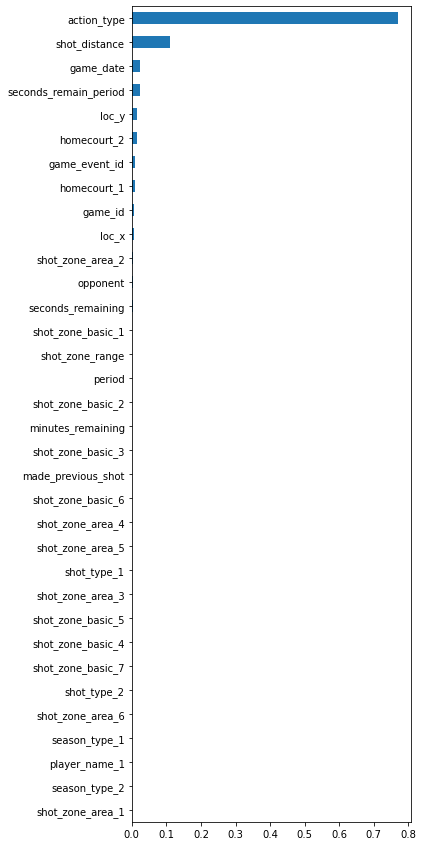

In [192]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,15))
feature_importance = pd.Series(best_pipe.named_steps['randomforestclassifier'].feature_importances_, best_pipe.named_steps['onehotencoder'].get_feature_names())

feature_importance.sort_values().plot.barh()